## Notebook Outline
* **Data transform and storage**  I have taken data directly from the original source. All the data is present as a txt file. We will run a pre-process procedure to clean a data little bit and store it in more usable format later i.e in a `csv` file.
* **Data cleaning** Since we have text data in hand, we are going to apply standard cleaning pipelines using various nlp tools available. 



DataSource <a href = "http://ai.stanford.edu/~amaas/data/sentiment/">here</a>


In [159]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import os
import warnings
warnings.filterwarnings("ignore")

In [160]:
data_source_path = "./IMDB_raw_movie_review_data/"

In [161]:
os.listdir(data_source_path)

['cleaned_imdb_reviews.csv',
 'imdb.vocab',
 'imdbEr.txt',
 'README',
 'test',
 'train',
 'transformed_data_reviews.csv']

In [162]:
os.listdir(data_source_path+"/train")

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [163]:
 os.listdir(data_source_path+"/test")

['labeledBow.feat', 'neg', 'pos', 'urls_neg.txt', 'urls_pos.txt']

In [164]:
os.listdir(data_source_path+"/train/neg")[:10]

['0_3.txt',
 '10000_4.txt',
 '10001_4.txt',
 '10002_1.txt',
 '10003_1.txt',
 '10004_3.txt',
 '10005_3.txt',
 '10006_4.txt',
 '10007_1.txt',
 '10008_2.txt']

In [165]:
os.listdir(data_source_path+"/test/neg")[:10]

['0_2.txt',
 '10000_4.txt',
 '10001_1.txt',
 '10002_3.txt',
 '10003_3.txt',
 '10004_2.txt',
 '10005_2.txt',
 '10006_2.txt',
 '10007_4.txt',
 '10008_4.txt']

* As we can see data is divided into `test` and `train` folders. And the `labels` are represented as folders i.e `pos` and `neg` here.
* each review is represented as `/train/neg/0_3.txt` i.e id for this review is `0`, star rating for that review on a 1-10 scale is `3` and the label for this review is `neg` and the data belongs to `train-set`

### Data transformation

In [166]:
sets = ['train','test']
labels = ['pos','neg']

labels_dict = dict(pos = 0,neg = 1)

In [167]:
def transform_data(base_data_source_path):
    """
    This function will read each review and it's corresponding label and other useful info one by one.
    Will perform a small clean-up step i.e strip operation to get rid of extra spaced and store the review
    and it's information in a dataFrame row.
    At the end it will return the populated dataFrame
    
    parameters :
    base_data_source_path - base path where the dataset is present in raw form
    
    returns :
    a dataFrame populated with reviews and some meta-data
    """
    
    df_columns = ['id','text','rating','label']
    
    rows = []
    
    for set_ in tqdm(sets,total = len(sets),unit = "set "):
        
        for label in labels:
            current_path = base_data_source_path+f"{set_}/{label}"
            files = os.listdir(current_path)
            for f in tqdm(files,total = len(files),unit = "review ",leave = False):
                file_name_tokens = f.split(".")[0].split("_")
                
                review_id = file_name_tokens[0]
                
                review_rating = file_name_tokens[1]
                
                review_data = None
                
                with open(current_path+f"/{f}","r", encoding="utf8") as Fp:
                    review_data = Fp.read()
                
                review_data = review_data.strip()
                
                rows.append((review_id,review_data,review_rating,label))
        
    return pd.DataFrame(columns = df_columns,data = rows)    

In [168]:
df_reviews = transform_data(data_source_path)

In [169]:
df_reviews.sample(20)

,id,text,rating,label
21475,6829,I've written at least a half dozen scathing re...,1,neg
42188,2970,"42/100. Often referred as ""Tarzan with clothes...",4,neg
16870,2684,I've found the movie offensive for Americans w...,1,neg
11298,891,What can I add that the previous comments have...,10,pos
22235,7512,I had to walk out of the theater. After an hou...,1,neg
22183,7466,Wow. Some movies just leave me speechless. Thi...,1,neg
32622,5610,"Hartley on low-key form: Martin Donovan, born ...",7,pos
26548,11394,What has to change in today's attitude towards...,10,pos
25817,10736,I think not! I mean yeah if you compare this f...,9,pos
48409,856,"Okay, now I am pretty sure that my summary got...",3,neg


In [170]:
df_reviews.shape

(50000, 4)

In [171]:
# save the transformed_data

df_reviews.to_csv("./IMDB_raw_movie_review_data/transformed_data_reviews.csv",index = False)

### Data-cleaning

In [172]:
# read the transformed-data

df_reviews = pd.read_csv(data_source_path+"transformed_data_reviews.csv")

In [173]:
df_reviews.head()

,id,text,rating,label
0,0,Bromwell High is a cartoon comedy. It ran at t...,9,pos
1,10000,Homelessness (or Houselessness as George Carli...,8,pos
2,10001,Brilliant over-acting by Lesley Ann Warren. Be...,10,pos
3,10002,This is easily the most underrated film inn th...,7,pos
4,10003,This is not the typical Mel Brooks film. It wa...,8,pos


In [174]:
# nlp

import spacy
import nltk
from bs4 import BeautifulSoup
from sklearn.feature_extraction import stop_words
from spacy.lemmatizer import Lemmatizer
from spacy.tokenizer import Tokenizer
from spacy.lookups import Lookups
from nltk.tokenize import word_tokenize
import re
import string

lemmatizer = Lemmatizer(Lookups())

nlp = spacy.load("en_core_web_sm")

stop_words_sklearn = list(stop_words.ENGLISH_STOP_WORDS)
stop_words_spacy = list(nlp.Defaults.stop_words)

stop_words = list(set(stop_words_sklearn + stop_words_spacy)) # all the stop words

In [175]:
# pre-process pipeline

def cleanpunc(review):
    nopunc = [char for char in review if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return nopunc

def remove_html_content(review):
    """
    remove html content if any using bs4
    """
    return BeautifulSoup(review).get_text()

def tokenization(review):
    return word_tokenize(review)
    

def remove_stop_words(review):
    return [word for word in review if not word in stop_words]
    
    
def lemmatization(review):
    return [lemmatizer.lookup(word) for word in review] 


def clean_data(reviews):
    """
    the transform fn that will apply all the transforms
    """
    transformed_reviews = []
    
    for review in tqdm(reviews,total = reviews.shape[0],unit = "review "):
        if len(review) != 0:
            review  = review.lower()
            review = remove_html_content(review)
            review = cleanpunc(review)
            review_tok = tokenization(review)
            review = remove_stop_words(review_tok)
            review_lem = lemmatization(review)
            
            transformed_reviews.append(" ".join(review_lem))
            
    return np.array(transformed_reviews)       

In [176]:
# let's apply the above pipeline

df_reviews.text = clean_data(df_reviews.text)

In [177]:
df_reviews.text.values[:2]

array(['bromwell high cartoon comedy ran time programs school life teachers 35 years teaching profession lead believe bromwell highs satire closer reality teachers scramble survive financially insightful students right pathetic teachers pomp pettiness situation remind schools knew students saw episode student repeatedly tried burn school immediately recalled high classic line inspector im sack teachers student welcome bromwell high expect adults age think bromwell high far fetched pity isnt',
       'homelessness houselessness george carlin stated issue years plan help street considered human going school work vote matter people think homeless lost cause worrying things racism war iraq pressuring kids succeed technology elections inflation worrying theyll end streetsbut given bet live streets month luxuries home entertainment sets bathroom pictures wall computer treasure like homeless goddard bolts lessonmel brooks directs stars bolt plays rich man world deciding bet sissy rival jeffer

In [178]:
# save the cleaned reviews

df_reviews.to_csv(data_source_path+"cleaned_imdb_reviews.csv",index = False)

### Some visuals and  feature eng.

In [179]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")

In [180]:
# read the cleaned reviews

df_reviews = pd.read_csv(data_source_path+"cleaned_imdb_reviews.csv")

In [181]:
df_reviews.head()

,id,text,rating,label
0,0,bromwell high cartoon comedy ran time programs...,9,pos
1,10000,homelessness houselessness george carlin state...,8,pos
2,10001,brilliant overacting lesley ann warren best dr...,10,pos
3,10002,easily underrated film inn brooks cannon sure ...,7,pos
4,10003,typical mel brooks film slapstick movies actua...,8,pos


In [182]:
# group by on ratings

df_reviews.groupby('rating').size()

rating
1     10122
2      4586
3      4961
4      5331
7      4803
8      5859
9      4607
10     9731
dtype: int64

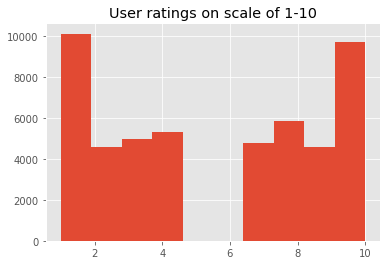

In [183]:
plt.hist(df_reviews.rating)
plt.title("User ratings on scale of 1-10")
plt.show()

**Observation** - Most reviews are rated either 1 or 10. No review has ratings = `5` or `6`

In [184]:
df_reviews[['text','label']].groupby("label").describe()

text                                                               
       count unique                                                top freq
label                                                                      
neg    25000  24695  got movie free job similar movies watched low ...    3
pos    25000  24883  loved todays variety solely cooking great stim...    5

In [185]:
# class distribution

df_reviews['label'].value_counts()

pos    25000
neg    25000
Name: label, dtype: int64

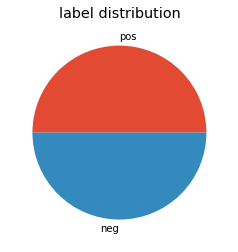

In [186]:
plt.pie(df_reviews['label'].value_counts(),labels = ['pos','neg'])
plt.title("label distribution")
plt.show()

**Observation** - Perfectly balanced class labels

In [187]:
reviews = df_reviews[['text','label']]

In [188]:
reviews.head()

,text,label
0,bromwell high cartoon comedy ran time programs...,pos
1,homelessness houselessness george carlin state...,pos
2,brilliant overacting lesley ann warren best dr...,pos
3,easily underrated film inn brooks cannon sure ...,pos
4,typical mel brooks film slapstick movies actua...,pos


In [189]:
# add a review length feature 

reviews['length'] = reviews['text'].apply(len)

In [190]:
reviews.head()

,text,label,length
0,bromwell high cartoon comedy ran time programs...,pos,487
1,homelessness houselessness george carlin state...,pos,1290
2,brilliant overacting lesley ann warren best dr...,pos,517
3,easily underrated film inn brooks cannon sure ...,pos,361
4,typical mel brooks film slapstick movies actua...,pos,307


In [191]:
print("(min,max review lenghts) - ",(reviews.length.min(),reviews.length.max()))

(min,max review lenghts) -  (17, 8625)


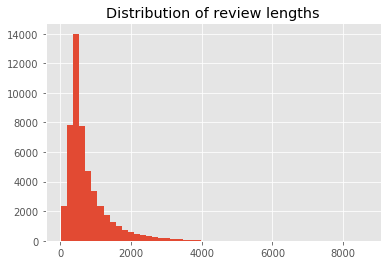

In [192]:
# plot the distributions of len

plt.hist(reviews.length,bins = 50)
plt.title("Distribution of review lengths")
plt.show()

In [193]:
# some information about the lengths

reviews.length.describe()

count    50000.000000
mean       748.574380
std        586.307924
min         17.000000
25%        385.000000
50%        548.000000
75%        914.250000
max       8625.000000
Name: length, dtype: float64

**Observation** - looks like we have a very long review i.e having length = 8677. Let's see that review

In [195]:
reviews[reviews['length'] == 8625]['text'].iloc[0]

'match 1 tag team table match bubba ray spike dudley vs eddie guerrero chris benoit bubba ray spike dudley started things tag team table match eddie guerrero chris benoit according rules match opponents tables order win benoit guerrero heated early taking turns hammering spike bubba ray german suplex benoit bubba took wind dudley brother spike tried help brother referee restrained benoit guerrero ganged corner benoit stomping away bubba guerrero set table outside spike dashed ring somersaulted rope guerrero outside recovering taking care spike guerrero slipped table ring helped wolverine set tandem set double superplex middle rope bubba table spike knocked table right brother came crashing guerrero benoit propped table corner tried irish whip spike bubba dashed blocked brother bubba caught lifted opponents body drops bubba slammed guerrero spike stomped wolverine rope bubba held benoit bay spike soar wassup headbutt shortly benoit latched spike crossface match continued spike tapped bu

### Modeling


In [196]:
# now let's convert the text into numerical representation.

from sklearn.feature_extraction.text import CountVectorizer

In [197]:
bow_transformer = CountVectorizer().fit(reviews.text)

In [199]:
len(bow_transformer.vocabulary_)

221238

In [200]:
sample_message = reviews.text.iloc[4]
sample_message

'typical mel brooks film slapstick movies actually plot followable leslie ann warren movie fantastic underrated actress moments fleshed bit scenes probably cut room worth price rent acting good overall brooks good job characteristic speaking directly audience warren best actor movie fume sailor played parts'

In [202]:
sample_transformed = bow_transformer.transform([sample_message])

In [205]:
# a sparse matrix

print(sample_transformed)

print("shape : ",sample_transformed.shape)

  (0, 5822)	1
  (0, 6217)	1
  (0, 6425)	1
  (0, 6531)	1
  (0, 12048)	1
  (0, 16465)	1
  (0, 22506)	1
  (0, 23844)	1
  (0, 28692)	2
  (0, 35264)	1
  (0, 47685)	1
  (0, 54211)	1
  (0, 69666)	1
  (0, 72027)	1
  (0, 74301)	1
  (0, 75097)	1
  (0, 78030)	1
  (0, 82868)	2
  (0, 104470)	1
  (0, 112468)	1
  (0, 122865)	1
  (0, 127029)	1
  (0, 129017)	2
  (0, 129575)	1
  (0, 142232)	1
  (0, 144714)	1
  (0, 149395)	1
  (0, 149753)	1
  (0, 153469)	1
  (0, 153836)	1
  (0, 161589)	1
  (0, 165519)	1
  (0, 167374)	1
  (0, 169332)	1
  (0, 178569)	1
  (0, 182238)	1
  (0, 203368)	1
  (0, 204653)	1
  (0, 211461)	2
  (0, 217748)	1
shape :  (1, 221238)


In [207]:
# now let's transform the entire reviews

reviews_transformed_bow = bow_transformer.transform(reviews.text)

print("Shape of entire transformed data : ",reviews_transformed_bow.shape)

# since it will be a sparse matrix we can count no of non-zero elements

print("Non-Zero elements : ",reviews_transformed_bow.nnz)

Shape of entire transformed data :  (50000, 221238)
Non-Zero elements :  4365356


In [208]:
# Now we have transformed the text into numerical form.
# But we can also assign a weights to each word by using Tf-Idf 

from sklearn.feature_extraction.text import TfidfTransformer

In [210]:
tf_idf_transformer = TfidfTransformer().fit(reviews_transformed_bow)

In [218]:
# let's see the tf-idf transformed version of the sample we have used earlier
sample_transformed_tfidf = tf_idf_transformer.transform(sample_transformed)
print(sample_transformed_tfidf) # each word has now a probablity assigned to it.

  (0, 217748)	0.09540094558207422
  (0, 211461)	0.37656471727729884
  (0, 204653)	0.15556757911139552
  (0, 203368)	0.12590501523469033
  (0, 182238)	0.14676835873213936
  (0, 178569)	0.16099404381002486
  (0, 169332)	0.07874105947387403
  (0, 167374)	0.19930806413934105
  (0, 165519)	0.12468049502771246
  (0, 161589)	0.12792560668677466
  (0, 153836)	0.0917520041958287
  (0, 153469)	0.1553923035722736
  (0, 149753)	0.07274147234514643
  (0, 149395)	0.09571654478972869
  (0, 144714)	0.11453226369558171
  (0, 142232)	0.11472993830944923
  (0, 129575)	0.06918975589696753
  (0, 129017)	0.0829982523776984
  (0, 127029)	0.10674294639955594
  (0, 122865)	0.17741901690859563
  (0, 112468)	0.1748164292574346
  (0, 104470)	0.09919484093384666
  (0, 82868)	0.10945238499662319
  (0, 78030)	0.27084597030567475
  (0, 75097)	0.2750744049283481
  (0, 74301)	0.20402200751680974
  (0, 72027)	0.04429582437975536
  (0, 69666)	0.12758537871527953
  (0, 54211)	0.16208703814168568
  (0, 47685)	0.12212317390

In [214]:
# transform all the reviews

reviews_transformed_tfidf = tf_idf_transformer.transform(reviews_transformed_bow)

In [215]:
reviews_transformed_tfidf.shape

(50000, 221238)

Let's apply `Naive bayes classifier`

In [216]:
from sklearn.naive_bayes import MultinomialNB

**In case of Naive bayes**

There is only one `hyper parameter` to tune i.e $\alpha $ Which represents `Additive (Laplace/Lidstone) smoothing parameter.`

* $\alpha=0$ i.e no smoothing will lead to high variance i.e under-fitting
* $\alpha=large-value$ will lead to high bias i.e under fitting

In [217]:
review_classifier = MultinomialNB().fit(reviews_transformed_tfidf,reviews.label)

In [219]:
# let's check the classifier

# data 

reviews[reviews.text == sample_message]

,text,label,length
4,typical mel brooks film slapstick movies actua...,pos,307


In [220]:
# prediction from model

predicted_sample = review_classifier.predict(sample_transformed_tfidf)

In [221]:
predicted_sample # same as true label

array(['pos'], dtype='<U3')

Now we have a working model

In [222]:
# let's predict all data points

predicted_all = review_classifier.predict(reviews_transformed_tfidf)

In [223]:
# let's look at some classification metrics

from sklearn.metrics import classification_report,confusion_matrix

In [233]:
def print_classification_report(true_labels,predicted_labels):
    """
    to print classification report and confusion matrix
    """
    # print classification report
    print("Classification report ")
    print(classification_report(true_labels,predicted_labels))

    print("*"*100)

    print("Confusion metrics ")
    print(pd.DataFrame(data = confusion_matrix(true_labels,predicted_labels)))

In [234]:
print_classification_report(reviews.label,predicted_all)

Classification report 
              precision    recall  f1-score   support

         neg       0.91      0.92      0.92     25000
         pos       0.92      0.91      0.92     25000

    accuracy                           0.92     50000
   macro avg       0.92      0.92      0.92     50000
weighted avg       0.92      0.92      0.92     50000

****************************************************************************************************
Confusion metrics 
       0      1
0  23114   1886
1   2223  22777


**Looks like we have a nice classifier but wait we did a `blunder`. We applied classification report on training data as we did not have test data**

**Hence we have no idea about the true predictive power of our classifier**

**Let's apply the model in right way** 

We will also use pipelines

In [235]:
# perform test and train split

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [236]:
review_train,review_test,label_train,label_test = train_test_split(reviews.text.values,reviews.label.values,
                                                                    test_size = 0.2, stratify = reviews.label.values,
                                                                  random_state = 0)

In [239]:
print(review_train.shape,review_test.shape)

(40000,) (10000,)


In [274]:
# pipeline to perform the steps in one go
review_pipeline = Pipeline(steps = [
    ('bow_transform',CountVectorizer()),
    ('tfidf_transform',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

In [275]:
review_pipeline.fit(review_train,label_train)

Pipeline(memory=None,
         steps=[('bow_transform',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf_transform',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [276]:
predictions_test = review_pipeline.predict(review_test)

In [277]:
# print the classification report

print_classification_report(label_test,predictions_test)

Classification report 
              precision    recall  f1-score   support

         neg       0.86      0.87      0.86      5000
         pos       0.87      0.85      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

****************************************************************************************************
Confusion metrics 
      0     1
0  4358   642
1   730  4270


In [263]:
# let's also see what is the accuracy 

from sklearn.metrics import accuracy_score

In [264]:
accuracy_score(label_test,predictions_test)

0.8628

**Looks like we have a pretty good model**

**But What about cross validation and hyper-parameter search ?**


- we can use `sklearn.model_selection.GridSearchCV` or `sklearn.model_selection.RandomizedSearchCV` to find best hyper-parameter. But how does `sklearn` do that -- By using `Cross validation`

In [265]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In case of `GridSearchCV` we have to provide a list of possible hyper-parameters as a dictionary in case we have only one hyper-parameter to tune or a list of dictionaries. On the other hand in `RandomizedSearchCV` we have to provide a distribution from which the value of hyper-parameters will be sampled randomly.

In [292]:
from sklearn.metrics import f1_score,make_scorer

In [302]:
# modeling using GridSearchCV

f1_scorer = make_scorer(f1_score, pos_label="pos")

parameter_to_tune = {"classifier__alpha":[0.5,0.6,0.7,0.8]} # pipeline name of the our algo or estimator

model_grid_search = GridSearchCV(review_pipeline,
                                 param_grid = parameter_to_tune,
                                 scoring = f1_scorer,cv = 3)

In [303]:
model_grid_search.fit(review_train,label_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('bow_transform',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                   

In [305]:
model_grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('bow_transform',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf_transform',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=0.7, class_prior=None, fit_prior=True))],
         verbose=False)

In [306]:
# let's check model score on test data

model_grid_search.score(review_test,label_test)

0.8614950065570464

In [307]:
predicted_test_gridsearch = model_grid_search.predict(review_test)

In [308]:
print_classification_report(label_test,predicted_test_gridsearch)

Classification report 
              precision    recall  f1-score   support

         neg       0.86      0.87      0.86      5000
         pos       0.87      0.85      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

****************************************************************************************************
Confusion metrics 
      0     1
0  4357   643
1   730  4270


In [323]:
# modeling using randomizedSearchCV

from scipy.stats import uniform


distributions = dict(classifier__alpha=uniform(loc=0, scale=4))


model_randSearch = RandomizedSearchCV(review_pipeline,distributions,
                                 scoring = f1_scorer,cv = 3)

In [324]:
model_randSearch.fit(review_train,label_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('bow_transform',
                                              CountVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.int64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                 

In [325]:
model_randSearch.best_estimator_

Pipeline(memory=None,
         steps=[('bow_transform',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf_transform',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=0.5448322875490428, class_prior=None,
                               fit_prior=True))],
  

In [326]:
predicted_test_Randsearch = model_randSearch.predict(review_test)

In [328]:
print_classification_report(label_test,predicted_test_Randsearch)

Classification report 
              precision    recall  f1-score   support

         neg       0.86      0.87      0.86      5000
         pos       0.87      0.86      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

****************************************************************************************************
Confusion metrics 
      0     1
0  4354   646
1   724  4276


**As we can see we are not observing any improvement in our model at all**

Yup no use of hyper-parameter search in this case. Or we may have failed to find best hyper-param space.

**Let's try one more simple model i.e `logistic regression`**

In [329]:
from sklearn.linear_model import LogisticRegression

In [330]:
# create pipeline for logistic regression


logistic_review_pipeline = Pipeline(steps = [
    ('bow_transform',CountVectorizer()),
    ('tfidf_transform',TfidfTransformer()),
    ('classifier',LogisticRegression())
])

In [331]:
logistic_review_pipeline.fit(review_train,label_train)

Pipeline(memory=None,
         steps=[('bow_transform',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocab...
                ('tfidf_transform',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, interce

In [332]:
predicted_test_log = logistic_review_pipeline.predict(review_test)

print_classification_report(label_test,predicted_test_log)

Classification report 
              precision    recall  f1-score   support

         neg       0.91      0.88      0.89      5000
         pos       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

****************************************************************************************************
Confusion metrics 
      0     1
0  4413   587
1   462  4538


**Wow looks like logistic regression is performing well**

In [339]:
# let's do some hyper-param search for logistic reg

f1_scorer = make_scorer(f1_score, pos_label="pos")

parameter_to_tune = {"classifier__C":[1,2,3,4,5,6,7,8,9,10,10,11,12]} # pipeline name of the our algo or estimator

model_grid_search = GridSearchCV(logistic_review_pipeline,
                                 param_grid = parameter_to_tune,
                                 scoring = f1_scorer,cv = 5)

In [340]:
model_grid_search.fit(review_train,label_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('bow_transform',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                   

In [341]:
model_grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('bow_transform',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocab...
                ('tfidf_transform',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 LogisticRegression(C=5, class_weight=None, dual=False,
                                    fit_intercept=True, intercept

In [342]:
predicted_test_log = model_grid_search.predict(review_test)

print_classification_report(label_test,predicted_test_log)

Classification report 
              precision    recall  f1-score   support

         neg       0.91      0.89      0.90      5000
         pos       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

****************************************************************************************************
Confusion metrics 
      0     1
0  4430   570
1   457  4543
